***installing Spacy 2.1.0 and neuralcoref***

> neuralcoref only works with Spacy, 2.1.0. Whilst spacy can be installe dusing Pip or Conda, to install the spacy lg english model and neuralcoref:
- https://v2.spacy.io/models/en
- manually download the model tar https://github.com/explosion/spacy-models/releases//tag/en_core_web_lg-2.3.1#
- install the model locally https://github.com/explosion/spaCy/issues/4577
- install neuralcoref from source
    - https://github.com/huggingface/neuralcoref/issues/197#issuecomment-534028423
    - https://github.com/huggingface/neuralcoref#install-neuralcoref-from-source



In [1]:
import re
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import spacy
import neuralcoref #
from spacy import displacy
try:
    nlp = spacy.load('en_core_web_lg')
except:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

## Load Data

In [2]:
df = pd.read_excel('tesco.xlsx',skiprows=2)
df[:2]

,id,text
0,0,"Tesco has been hit by hackers, leaving thousan..."
1,1,The outage leaves its grocery website and app ...


## Model

- [named entity recognition]()
- [coreference resolution](https://spacy.io/universe/project/neuralcoref)

 
<img src="./model_architecture.svg" width=600 height=400>

In [93]:
example_text = ('Johnny is a big fan of skiing. '
                'He is a man. '
                'Lydia is a woman who likes cycling. '
                'He also enjoys cycling but she is a fan of music. '
                'Tesco Plc is the lagest supermarket chain in the UK. '
                'Their customers shop on average three times per week. '
                'But they buy fuel from other places.'
               )
example_text

'Johnny is a big fan of skiing. He is a man. Lydia is a woman who likes cycling. He also enjoys cycling but she is a fan of music. Tesco Plc is the lagest supermarket chain in the UK. Their customers shop on average three times per week. But they buy fuel from other places.'

## Named Entity Recognition
To extract the named entities

In [90]:
# custom NER
try:
    nlp.remove_pipe('entity_ruler')
#     pass
except:
    config = {
       "phrase_matcher_attr": None,
       "validate": True,
       "overwrite_ents": True,
       "ent_id_sep": "||",
    }
    ruler = nlp.create_pipe("entity_ruler", config=config)
    patterns = [
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(customer)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(shopper)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(hacker)s?' }} ]},
                ]
    ruler.add_patterns(patterns)
    ruler = nlp.add_pipe(ruler)

In [91]:
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f3389244210>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f338929b600>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f338929b670>),
 ('neuralcoref', <neuralcoref.neuralcoref.NeuralCoref at 0x7f337c806cb0>),
 ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x7f337b8e0d90>)]

In [95]:
example_doc = nlp(example_text)
spacy.displacy.render(example_doc, style='dep')
print('\n\n')
spacy.displacy.render(example_doc, style='ent')

In [96]:
# pre-processing
df['text-clean'] = df['text'].apply(lambda x: re.sub(r"(\w+)'s", r'\1s', x))
# apply nlp
df['doc'] = df['text-clean'].apply(lambda x: nlp(x))

df[:2]

,id,text,text-clean,doc
0,0,"Tesco has been hit by hackers, leaving thousan...","Tesco has been hit by hackers, leaving thousan...","(Tesco, has, been, hit, by, hackers, ,, leavin..."
1,1,The outage leaves its grocery website and app ...,The outage leaves its grocery website and app ...,"(The, outage, leaves, its, grocery, website, a..."


### Coreference Resolution

In [98]:
try: 
    neuralcoref.add_to_pipe(nlp)
    print(nlp.pipeline)
except:
    print(nlp.pipeline)

[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7f3389244210>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7f338929b600>), ('ner', <spacy.pipeline.pipes.EntityRecognizer object at 0x7f338929b670>), ('neuralcoref', <neuralcoref.neuralcoref.NeuralCoref object at 0x7f337c806cb0>), ('entity_ruler', <spacy.pipeline.entityruler.EntityRuler object at 0x7f337b8e0d90>)]


In [99]:
print(example_doc)

Johnny is a big fan of skiing. He is a man. Lydia is a woman who likes cycling. He also enjoys cycling but she is a fan of music. Tesco Plc is the lagest supermarket chain in the UK. Their customers shop on average three times per week. But they buy fuel from other places.


In [100]:
example_doc = nlp(example_text)
example_doc._.has_coref
example_doc._.coref_clusters

[Johnny: [Johnny, He, He],
 Lydia: [Lydia, she],
 Their customers: [Their customers, they]]

In [101]:
example_doc.ents

(Johnny, Lydia, Tesco Plc, UK, customers, three)

In [102]:
example_doc._.coref_resolved

'Johnny is a big fan of skiing. Johnny is a man. Lydia is a woman who likes cycling. Johnny also enjoys cycling but Lydia is a fan of music. Tesco Plc is the lagest supermarket chain in the UK. Their customers shop on average three times per week. But Their customers buy fuel from other places.'

In [103]:
example_doc._.coref_scores
k = example_doc._.coref_clusters
k[0],k[1]

(Johnny: [Johnny, He, He], Lydia: [Lydia, she])

In [104]:
# mentions
k[0].main.start_char,k[0].main.end_char
a = k[0].mentions
print(a)

for i in a:
    print(i,i.start_char,i.end_char)

[Johnny, He, He]
Johnny 0 6
He 31 33
He 80 82


In [106]:
example_doc = nlp(example_doc._.coref_resolved)
spacy.displacy.render(example_doc, style='ent')

### Relation Extraction

In [118]:
# example doc
doc = example_doc

for tok in doc:
    if tok.pos_ in ['PROPN','NOUN','PRON']:
        print((tok.text.title(),tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))
    else:
        print('\t',(tok.text.title(),tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))

('Johnny', 'PROPN', 'nsubj', 'PERSON', 0, 0)
	 ('Is', 'AUX', 'ROOT', '', 1, 7)
	 ('A', 'DET', 'det', '', 2, 10)
	 ('Big', 'ADJ', 'amod', '', 3, 12)
('Fan', 'NOUN', 'attr', '', 4, 16)
	 ('Of', 'ADP', 'prep', '', 5, 20)
('Skiing', 'NOUN', 'pobj', '', 6, 23)
	 ('.', 'PUNCT', 'punct', '', 7, 29)
('Johnny', 'PROPN', 'nsubj', 'PERSON', 8, 31)
	 ('Is', 'AUX', 'ROOT', '', 9, 38)
	 ('A', 'DET', 'det', '', 10, 41)
('Man', 'NOUN', 'attr', '', 11, 43)
	 ('.', 'PUNCT', 'punct', '', 12, 46)
('Lydia', 'PROPN', 'nsubj', 'PERSON', 13, 48)
	 ('Is', 'AUX', 'ROOT', '', 14, 54)
	 ('A', 'DET', 'det', '', 15, 57)
('Woman', 'NOUN', 'attr', '', 16, 59)
('Who', 'PRON', 'nsubj', '', 17, 65)
	 ('Likes', 'VERB', 'relcl', '', 18, 69)
('Cycling', 'NOUN', 'xcomp', '', 19, 75)
	 ('.', 'PUNCT', 'punct', '', 20, 82)
('Johnny', 'PROPN', 'nsubj', 'PERSON', 21, 84)
	 ('Also', 'ADV', 'advmod', '', 22, 91)
	 ('Enjoys', 'VERB', 'ROOT', '', 23, 96)
('Cycling', 'NOUN', 'dobj', '', 24, 103)
	 ('But', 'CCONJ', 'cc', '', 25, 111)


In [108]:
# get entities
def get_entities(doc):
    entities = dict()
    for tok in doc:
        if tok.pos_ in ['PROPN','NOUN','PRON']:
            entities[tok.i] = tok # token.i is int location in doc
            # print((tok.text.title(),tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))
    return entities

entities = get_entities(doc)
entities

{0: Johnny,
 4: fan,
 6: skiing,
 8: Johnny,
 11: man,
 13: Lydia,
 16: woman,
 17: who,
 19: cycling,
 21: Johnny,
 24: cycling,
 26: Lydia,
 29: fan,
 31: music,
 33: Tesco,
 34: Plc,
 37: lagest,
 38: supermarket,
 39: chain,
 42: UK,
 45: customers,
 50: times,
 52: week,
 56: customers,
 58: fuel,
 61: places}

In [109]:
# get ordered entity pairs
def get_entity_pairs(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return {e:{'from':x[0],'to':x[1]} for e,x in enumerate(zip(a, b))}
entity_pairs = get_entity_pairs(entities.keys())
entity_pairs

{0: {'from': 0, 'to': 4},
 1: {'from': 4, 'to': 6},
 2: {'from': 6, 'to': 8},
 3: {'from': 8, 'to': 11},
 4: {'from': 11, 'to': 13},
 5: {'from': 13, 'to': 16},
 6: {'from': 16, 'to': 17},
 7: {'from': 17, 'to': 19},
 8: {'from': 19, 'to': 21},
 9: {'from': 21, 'to': 24},
 10: {'from': 24, 'to': 26},
 11: {'from': 26, 'to': 29},
 12: {'from': 29, 'to': 31},
 13: {'from': 31, 'to': 33},
 14: {'from': 33, 'to': 34},
 15: {'from': 34, 'to': 37},
 16: {'from': 37, 'to': 38},
 17: {'from': 38, 'to': 39},
 18: {'from': 39, 'to': 42},
 19: {'from': 42, 'to': 45},
 20: {'from': 45, 'to': 50},
 21: {'from': 50, 'to': 52},
 22: {'from': 52, 'to': 56},
 23: {'from': 56, 'to': 58},
 24: {'from': 58, 'to': 61}}

In [110]:
# get edge text
def get_entity_edges(entity_pairs):
    for k in list(entity_pairs.keys()):
        v = entity_pairs[k]
        edge_text = [t.text for t in doc[v['from']:v['to']+1] if t.pos_ in ['VERB','ADP','ADJ']]
        edge_text = ' '.join(edge_text)
        if len(edge_text) == 0:
            del entity_pairs[k]
        else:
            v['edge'] = edge_text
    
get_entity_edges(entity_pairs)
entity_pairs

{0: {'from': 0, 'to': 4, 'edge': 'big'},
 1: {'from': 4, 'to': 6, 'edge': 'of'},
 7: {'from': 17, 'to': 19, 'edge': 'likes'},
 9: {'from': 21, 'to': 24, 'edge': 'enjoys'},
 12: {'from': 29, 'to': 31, 'edge': 'of'},
 18: {'from': 39, 'to': 42, 'edge': 'in'},
 20: {'from': 45, 'to': 50, 'edge': 'shop on average'},
 21: {'from': 50, 'to': 52, 'edge': 'per'},
 23: {'from': 56, 'to': 58, 'edge': 'buy'},
 24: {'from': 58, 'to': 61, 'edge': 'from other'}}

## view relations between entities and nouns

In [111]:
# create graph
G=nx.Graph(name='simple KG')

for k,node in entities.items():
    G.add_node(k,name=node.text.title(), ent_typ=node.ent_type_, pos=node.pos_) 
node_labels = {node[0]:node[1]['name'] for node in G.nodes(data=True)}

edges = [(v['from'],v['to'],{'weight':1}) for v in entity_pairs.values()]
edge_labels = {(v['from'],v['to']):v['edge'] for v in entity_pairs.values()}
G.add_edges_from(edges)

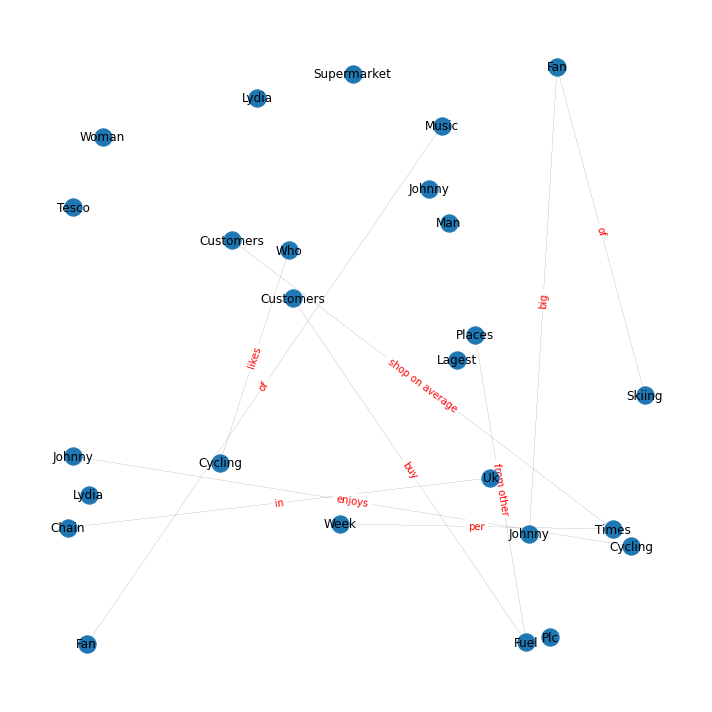

In [119]:
# plot graph
fig,ax = plt.subplots(1,1, figsize=(10,10))
pos = nx.random_layout(G,seed=13)
nx.draw(G, 
        ax=ax,
        pos=pos,
        labels=node_labels,
        width=0.1)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels,
                             font_color='red')
plt.tight_layout()